In [1]:
#!pip install --upgrade git+https://github.com/oKatanaaa/GCT

In [2]:
#!pip install --upgrade git+https://github.com/MakiResearchTeam/MakiFlow.git

In [3]:
#%tensorflow_version 1.x

In [4]:
from gct.tools import load_cifar10
import matplotlib.pyplot as plt
from makiflow.core.inference import Model
from makiflow.core.training.fitter_v2 import ModelFitter
from makiflow.losses import CustomLoss
from makiflow.generators.classification import cycle_generator
import tensorflow as tf
from makiflow.layers import *
import numpy as np
%matplotlib inline

In [5]:
(Xtrain, Ytrain), (Xtest, Ytest), (X_mean, X_std) = load_cifar10()

In [6]:
BATCH_SIZE = 64

In [7]:
def block(x, id, in_f, out_f):
    SX = x
    FX = x
    
    FX = BatchNormLayer(D=in_f, name=f'bn_main_{id}_1')(FX)
    FX = ActivationLayer(name=f'act_1_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=in_f, out_f=out_f, name=f'conv_main_{id}_1', activation=None)(FX)
    
    FX = BatchNormLayer(D=out_f, name=f'bn_main_{id}_2')(FX)
    FX = ActivationLayer(name=f'act_2_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=out_f, out_f=out_f, name=f'conv_main_{id}_2', activation=None)(FX)

    if in_f != out_f:
        SX = BatchNormLayer(D=in_f, name=f'bn_skip_{id}_1')(SX)
        SX = ConvLayer(kw=1, kh=1, in_f=in_f, out_f=out_f, name=f'conv_skip_{id}', activation=None)(SX)
    
    x_sum = SumLayer(name=f'sum_{id}')([FX, SX])
    return x_sum

In [8]:
# Create a model

In [9]:
inp = InputLayer(input_shape=[None, 32, 32, 3], name='input')
x = block(inp, id=1, in_f=3, out_f=32)
x = MaxPoolLayer(name='mp1')(x)
# 16x16
x = block(x, id=2, in_f=32, out_f=64)
x = block(x, id=3, in_f=64, out_f=64)
x = MaxPoolLayer(name='mp2')(x)
# 8x8
x = block(x, id=4, in_f=64, out_f=128)
x = block(x, id=5, in_f=128, out_f=128)
x = MaxPoolLayer(name='mp3')(x)
# 4x4
x = block(x, id=6, in_f=128, out_f=256)
x = block(x, id=7, in_f=256, out_f=256)
x = MaxPoolLayer(name='mp4')(x)
# 2x2
x = FlattenLayer('flat')(x)
# 4*256 = 1024
x_f = DenseLayer(in_d=1024, out_d=256, name='projection_head')(x)
# Head1
x = DenseLayer(in_d=256, out_d=10, activation=None, name='classification_head1')(x_f)
x = ConcatLayer(name='concat1', axis=-1)([x, x_f])

# Head2
x = DenseLayer(in_d=266, out_d=10, activation=None, name='classification_head2')(x)
x = ConcatLayer(name='concat2', axis=-1)([x, x_f])

x = DenseLayer(in_d=266, out_d=10, activation=None, name='classification_head3')(x)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [10]:
model = Model(inputs=[inp], outputs=[x], name='MakiResNet')
sess = tf.Session()
model.set_session(sess)

In [11]:
# Setup training

In [42]:
def cross_entropy(prediction, label_tensors):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_tensors['labels'], logits=prediction)
    return tf.reduce_mean(loss)

In [43]:
loss1 = CustomLoss(
    tensor_names=['classification_head1', 'classification_head2', 'classification_head3'], 
    label_tensors={'labels': tf.placeholder(dtype='int32', shape=[BATCH_SIZE])},
    loss_fn=cross_entropy
)

In [44]:
loss1 = loss1 * 2 + loss1 / 3 + (loss1 + 1)

In [45]:
trainer = ModelFitter(model, [InputLayer(input_shape=[BATCH_SIZE, 32, 32, 3], name='input')], loss1)
# training_inputs - list, can contain generators

In [46]:
trainer.compile()

Loss is built.


In [47]:
opt = tf.train.AdamOptimizer()

In [48]:
gen = cycle_generator(Xtrain, Ytrain.reshape(-1), BATCH_SIZE)

In [49]:
info1 = trainer.fit_generator(gen, optimizer=opt, epochs=5, iter=100, print_period=10)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

New optimizer is used.


 16%|████████████▉                                                                    | 16/100 [00:01<00:04, 17.64it/s]

Epoch: 0
Training_Loss: 11.1230972 




 24%|███████████████████▍                                                             | 24/100 [00:01<00:02, 25.53it/s]

Epoch: 0
Training_Loss: 11.3946101 




 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:01, 32.70it/s]

Epoch: 0
Training_Loss: 11.6567841 




 48%|██████████████████████████████████████▉                                          | 48/100 [00:02<00:01, 36.05it/s]

Epoch: 0
Training_Loss: 11.6988209 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:02<00:01, 37.10it/s]

Epoch: 0
Training_Loss: 11.5716060 




 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:02<00:00, 37.48it/s]

Epoch: 0
Training_Loss: 11.0213933 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:03<00:00, 37.93it/s]

Epoch: 0
Training_Loss: 10.9674142 




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:03<00:00, 37.86it/s]

Epoch: 0
Training_Loss: 11.3747620 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:03<00:00, 34.98it/s]

Epoch: 0
Training_Loss: 11.4178853 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 38.82it/s]

Epoch: 0
Training_Loss: 10.7394497 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 38.20it/s]

Epoch: 1
Training_Loss: 10.7035620 




 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 38.65it/s]

Epoch: 1
Training_Loss: 10.5062654 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 38.90it/s]

Epoch: 1
Training_Loss: 10.8531689 




 48%|██████████████████████████████████████▉                                          | 48/100 [00:01<00:01, 38.91it/s]

Epoch: 1
Training_Loss: 10.7595351 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 38.87it/s]

Epoch: 1
Training_Loss: 10.6256075 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 38.92it/s]

Epoch: 1
Training_Loss: 10.6193651 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.87it/s]

Epoch: 1
Training_Loss: 10.5456896 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 38.84it/s]

Epoch: 1
Training_Loss: 10.5898223 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 38.72it/s]

Epoch: 1
Training_Loss: 10.7420690 




  8%|██████▌                                                                           | 8/100 [00:00<00:02, 39.37it/s]

Epoch: 1
Training_Loss: 10.5136551 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.00it/s]

Epoch: 2
Training_Loss: 9.7343113 




 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 38.75it/s]

Epoch: 2
Training_Loss: 10.1197240 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 37.51it/s]

Epoch: 2
Training_Loss: 10.1278883 




 44%|███████████████████████████████████▋                                             | 44/100 [00:01<00:01, 35.56it/s]

Epoch: 2
Training_Loss: 10.0704922 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 37.32it/s]

Epoch: 2
Training_Loss: 10.2007954 




 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:01<00:00, 38.15it/s]

Epoch: 2
Training_Loss: 9.9239181 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.90it/s]

Epoch: 2
Training_Loss: 9.5672984 




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:02<00:00, 39.05it/s]

Epoch: 2
Training_Loss: 9.8352288 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 38.88it/s]

Epoch: 2
Training_Loss: 9.7857657 




  8%|██████▌                                                                           | 8/100 [00:00<00:02, 38.82it/s]

Epoch: 2
Training_Loss: 9.7071745 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 38.87it/s]

Epoch: 3
Training_Loss: 9.5539382 




 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 38.67it/s]

Epoch: 3
Training_Loss: 9.8788599 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 38.99it/s]

Epoch: 3
Training_Loss: 9.4923866 




 48%|██████████████████████████████████████▉                                          | 48/100 [00:01<00:01, 39.33it/s]

Epoch: 3
Training_Loss: 9.4290951 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 38.91it/s]

Epoch: 3
Training_Loss: 9.5726393 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 38.80it/s]

Epoch: 3
Training_Loss: 9.6363352 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.00it/s]

Epoch: 3
Training_Loss: 9.3527736 




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:02<00:00, 35.50it/s]

Epoch: 3
Training_Loss: 9.0393359 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 37.11it/s]

Epoch: 3
Training_Loss: 9.1735642 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 39.60it/s]

Epoch: 3
Training_Loss: 9.0126272 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 38.79it/s]

Epoch: 4
Training_Loss: 8.8533505 




 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 38.77it/s]

Epoch: 4
Training_Loss: 8.9517556 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 38.69it/s]

Epoch: 4
Training_Loss: 9.1940837 




 44%|███████████████████████████████████▋                                             | 44/100 [00:01<00:01, 38.76it/s]

Epoch: 4
Training_Loss: 8.8913765 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 38.92it/s]

Epoch: 4
Training_Loss: 8.9873997 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 38.75it/s]

Epoch: 4
Training_Loss: 8.6721830 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 39.01it/s]

Epoch: 4
Training_Loss: 8.6202483 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 38.95it/s]

Epoch: 4
Training_Loss: 8.8243689 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 39.02it/s]

Epoch: 4
Training_Loss: 8.8268052 




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.82it/s]

Epoch: 4
Training_Loss: 9.1697167 




In [50]:
predictions = model.predict(Xtest)

10000it [00:26, 377.76it/s]


In [51]:
predictions = np.argmax(predictions, axis=-1)

In [52]:
np.mean(predictions == Ytest.reshape(-1))

0.6555

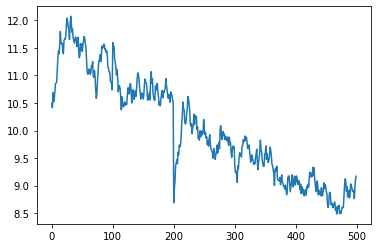

In [53]:
plt.plot(info1[trainer.TRAINING_LOSS])